## Implied Volatilities

In [1]:
from math import log, sqrt, exp
from scipy import stats
import pandas as pd

Black-Sholes-Merton Forumla for European call Options on an underlying without dividends.
 
$C(S_0,K,T,r,\sigma)=S_0N(d_1)-e^{-rT}KN(d_2)$
 
$N(d)=\frac{1}{\sqrt{2\pi}}\int_{-\infty}^d \mathrm{e}^{-\frac{1}{2}x^2}\mathrm{d}x$

$d_1=\frac{\log{\frac{S_0}{K}}+(r+\frac{\sigma^2}{2})T}{\sigma\sqrt{T}}$
 
$d_1=\frac{\log{\frac{S_0}{K}}+(r-\frac{\sigma^2}{2})T}{\sigma\sqrt{T}}$ 

In [2]:
def bsm_call_value(S0,K,T,r,sigma):
        
    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = (log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    value = (S0 * stats.norm.cdf(d1, 0.0, 1.0) - K * exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
    
    return value



Vega Formula.

$\frac{\partial C}{\partial\sigma}=S_0N(d_1)\sqrt{T}$

In [3]:
def bsm_vega(S0, K, T, r, sigma):

    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    vega = S0 * stats.norm.cdf(d1, 0.0, 1.0) * sqrt(T)
          
    return vega

Given the quote for the the option, implied volatility is the value that solves the implicit equation.

$C(S_0,K,T,r,\sigma^2)=C^*$

Resolution by Newton Scheme

$\sigma_{n+1}^{imp}=\sigma_{n}^{imp}-\frac{C(\sigma_{n}^{imp})-C^*}{\frac{\partial C(\sigma_{n}^{imp})}{\partial \sigma_{n}^{imp}}}$

In [4]:
def bsm_call_imp_vol(S0, K, T, r, C0, sigma_est, it=100):
    
    for i in range(it):
        sigma_est -= ((bsm_call_value(S0, K, T, r, sigma_est) - C0)
                        / bsm_vega(S0, K, T, r, sigma_est))
        
    return sigma_est

European call options on the VSTOXX index.

In [5]:
V0 = 17.6639 #Value at time 0
r = 0.01 #Risk free rate

with pd.HDFStore('C:\\Users\\Pau\\Desktop\\kike\\QUANt\\Python\\Data\\vstoxx_data_31032014.h5') as hdf:
    # This prints a list of all group names in HDF5 file:
    print(hdf.keys())

['/futures_data', '/options_data']


In [6]:
h5=pd.HDFStore('C:\\Users\\Pau\\Desktop\\kike\\QUANt\\Python\\Data\\vstoxx_data_31032014.h5')
futures_data=h5['/futures_data']
options_data=h5['/options_data']
h5.close()

Obtaining of option's implied volatilities 

In [7]:
options_data['IMP_VOL']=0.0
tol = 0.5  # tolerance level for moneyness
for option in options_data.index:
    # iterating over all option quotes
    forward = futures_data[futures_data['MATURITY'] == \
                options_data.loc[option]['MATURITY']]['PRICE'].values[0]
    if (forward * (1 - tol) < options_data.loc[option]['STRIKE']< forward * (1 + tol)):
                # only for options with moneyness within tolerance
            imp_vol = bsm_call_imp_vol(V0,# VSTOXX value
                    options_data.loc[option]['STRIKE'],
                        options_data.loc[option]['TTM'],
                        r,   # short rate
                        options_data.loc[option]['PRICE'],
                        sigma_est=2.,  # estimate for implied volatility
                        it=100)
            options_data['IMP_VOL'].loc[option] = imp_vol
            
print(options_data.head())
        

C:\Users\Pau\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


                      DATE  EXP_YEAR  EXP_MONTH TYPE  STRIKE  PRICE  \
46170  1396224000000000000      2014          4    C     1.0  16.85   
46171  1396224000000000000      2014          4    C     2.0  15.85   
46172  1396224000000000000      2014          4    C     3.0  14.85   
46173  1396224000000000000      2014          4    C     4.0  13.85   
46174  1396224000000000000      2014          4    C     5.0  12.85   

                  MATURITY    TTM  IMP_VOL  
46170  1397779200000000000  0.049      0.0  
46171  1397779200000000000  0.049      0.0  
46172  1397779200000000000  0.049      0.0  
46173  1397779200000000000  0.049      0.0  
46174  1397779200000000000  0.049      0.0  


Plot of Implied Volatilities and Strike by Maturity

C:\Users\Pau\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Pau\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Pau\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Pau\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Pau\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Pau\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Pau\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.

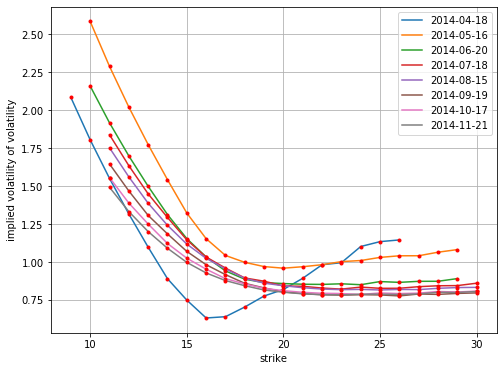

In [8]:
import datetime
import pytz

options_data['MATURITY_DATE'] = options_data['MATURITY']/(10**9) # the data has extra zeros... thats why why divide by 10^9
options_data['MATURITY_DATE'] = options_data['MATURITY_DATE'].apply(lambda x: datetime.datetime.\
                                                                    # convert to datetime object
                                                fromtimestamp(x,pytz.timezone("Europe/London")).\
                                                                    # set timezone
                                                strftime('%Y-%m-%d')) # datetime format

plot_data=options_data[options_data['IMP_VOL']>0] # select only the data that has non-zero values of implied volatitity

maturities=sorted(set(options_data['MATURITY'])) # sort the data by maturity

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8, 6))
for maturity in maturities:
    data = plot_data[options_data.MATURITY == maturity]
    # select data for this maturity
    plt.plot(data['STRIKE'], data['IMP_VOL'],
                      label=data.MATURITY_DATE.values[0], lw=1.5)
    plt.plot(data['STRIKE'], data['IMP_VOL'], 'r.')
plt.grid(True)
plt.xlabel('strike')
plt.ylabel('implied volatility of volatility')
plt.legend()
plt.show()